# Wikipedia Categories

## Topic Modelling (LDA)

Turkish Wikipedia dump from: https://www.kaggle.com/mustfkeskin/turkish-wikipedia-dump

In [25]:
import re
import requests
import os
import random
import codecs
import cPickle
import json
from gensim.models.ldamodel import LdaModel as Lda
from gensim import corpora
from nltk.stem.wordnet import WordNetLemmatizer

In [26]:
# Preparation of documents

trwikidumpfile = '../turkish-wikipedia-dump'

docs = {}

with open(trwikidumpfile) as trwikidump:
    data = ''
    title = ""
    for line in trwikidump:
        if '<doc' in line and 'title=' in line:
            title = re.sub(r'\<doc id\=\".*\" url\=\".*\" title=\"', '', line)
            title = title.replace('">', '')
        elif '</doc>' in line:
            docs[title.lower().strip()] = data
            title = ''
            data = ''
        else:
            data += line.decode('utf8') + '\n'

In [4]:
# get Turkish stop words
re = requests.get('https://raw.githubusercontent.com/ahmetax/trstop/master/dosyalar/turkce-stop-words')
stopwords = re.text
stopwords = re.text.split()

In [5]:
len(docs.values())

310290

In [6]:
# Topic modelling based on 
# https://github.com/abhijeet3922/Topic-Modelling-on-Wiki-corpus/blob/master/wiki_topic_model.py

# Function to remove stop words from sentences & lemmatize verbs. 
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stopwords])
    normalized = " ".join(lemma.lemmatize(word,'v') for word in stop_free.split())
    x = normalized.split()
    y = [s for s in x if len(s) > 2]
    return y

doc_complete = docs.values()

# Randomly sample 70000 articles from the corpus     
docs_all = random.sample(doc_complete, 70000)
#docs = open("docs_wiki.pkl",'wb')
#cPickle.dump(docs_all,docs)

# Use 60000 articles for training.
docs_train = docs_all[:60000]


# Cleaning all the 60,000 simplewiki articles
lemma = WordNetLemmatizer()
doc_clean = [clean(doc) for doc in docs_train]

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Filter the terms which have occured in less than 3 articles and more than 40% of the articles 
dictionary.filter_extremes(no_below=4, no_above=0.4)

#words,ids = dictionary.filter_n_most_frequent(50)
#print words,"\n\n",ids

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

#Creating the object for LDA model using gensim library & Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=50, id2word = dictionary, passes=50, iterations=500)
ldafile = open('lda_model_sym_wiki.pkl','wb')
cPickle.dump(ldamodel,ldafile)
ldafile.close()



1   0.019*"arap" + 0.011*"mısır" + 0.010*"petrol" + 0.009*"bronz" + 0.009*"kış" + 0.007*"suudi" + 0.007*"isveç" + 0.007*"mardin" + 0.006*"dinî" + 0.005*"sezonunu" 

2   0.057*"yılında" + 0.025*"tarihinde" + 0.015*"ilk" + 0.012*"eylül" + 0.012*"2008" + 0.012*"haziran" + 0.011*"2007" + 0.010*"temmuz" + 0.010*"2013" + 0.010*"ekim" 

3   0.050*"yer" + 0.044*"alan" + 0.038*"nüfus" + 0.033*"şehrin" + 0.032*"tarihinde" + 0.030*"edilmiştir." + 0.028*"tespit" + 0.028*"nüfusu" + 0.028*"amerika" + 0.026*"birleşik" 

4   0.009*"göl" + 0.007*"gölü" + 0.007*"marie" + 0.006*"formula" + 0.006*"metre" + 0.006*"arasında" + 0.005*"çanak" + 0.005*"normal" + 0.005*"taş" + 0.005*"baraj" 

5   0.007*"von" + 0.006*"sanatlar" + 0.006*"polat" + 0.005*"alman" + 0.004*"olmadığını" + 0.004*"üzerine" + 0.004*"güzel" + 0.004*"hakkında" + 0.004*"anlatır." + 0.004*"kendisinin" 

6   0.038*"hava" + 0.021*"uzay" + 0.017*"dil" + 0.013*"uçak" + 0.012*"dili" + 0.009*"uçuş" + 0.007*"dünya'nın" + 0.007*"dilleri" + 0.006*"hav

In [8]:
len(dictionary)

#Print all the 50 topics
#for topic in ldamodel.print_topics(num_topics=50, num_words=10):
#    print topic[0]+1, " ", topic[1],"\n"

100000

In [12]:
x = ''
for k,v in docs.iteritems():
    x = k
    break

print 'Title: ' + x

tokenized_document = docs[x].split()

ques_vec = dictionary.doc2bow(tokenized_document)
#topic_vec will contain the classified topic number (class) and the probability that the document belongs to that class
topic_vec = ldamodel[ques_vec]

topic_number = max(topic_vec,key=lambda item:item[1])[0]
print topic_number

words = ldamodel.show_topic(topic_number, topn = 10)
for w in words:
    print w

Title: rémy cabella

31
(u'ilk', 0.020509258)
(u'futbol', 0.017338768)
(u'sezonunda', 0.012901851)
(u'mill\xee', 0.01284077)
(u'sezon', 0.011190816)
(u'oldu.', 0.010767334)
(u'tak\u0131m\u0131', 0.010697887)
(u'transfer', 0.010609378)
(u'gol', 0.010345067)
(u'lig', 0.010126795)


In [13]:
# get edits before and after block per article
edits_articles_before = {}
with open('edits-per-article-before.json') as infile:
    edits_articles_before = json.load(infile)
edits_articles_after = {}
with open('edits-per-article-after.json') as infile:
    edits_articles_after = json.load(infile)

In [27]:
# get all article titles we have data on
article_titles_pre = set(edits_articles_after.keys() + edits_articles_before.keys())
article_titles = set()
for t in article_titles_pre:
    article_titles.add(t.replace('_', ' ').strip())

armerde


In [32]:
before = {}
after = {}
for x in article_titles:
    x = x.encode('utf-8')
    if x not in docs:
        counter += 1
        continue
    tokenized_document = docs[x].split()
    ques_vec = dictionary.doc2bow(tokenized_document)
    topic_vec = ldamodel[ques_vec]
    topic_number = max(topic_vec,key=lambda item:item[1])[0]
    
    if x in edits_articles_before:
        if topic_number in before:
            before[topic_number] += 1
        else:
            before[topic_number] = 1
    if x in edits_articles_after:
        if topic_number in after:
            after[topic_number] += 1
        else:
            after[topic_number] =1

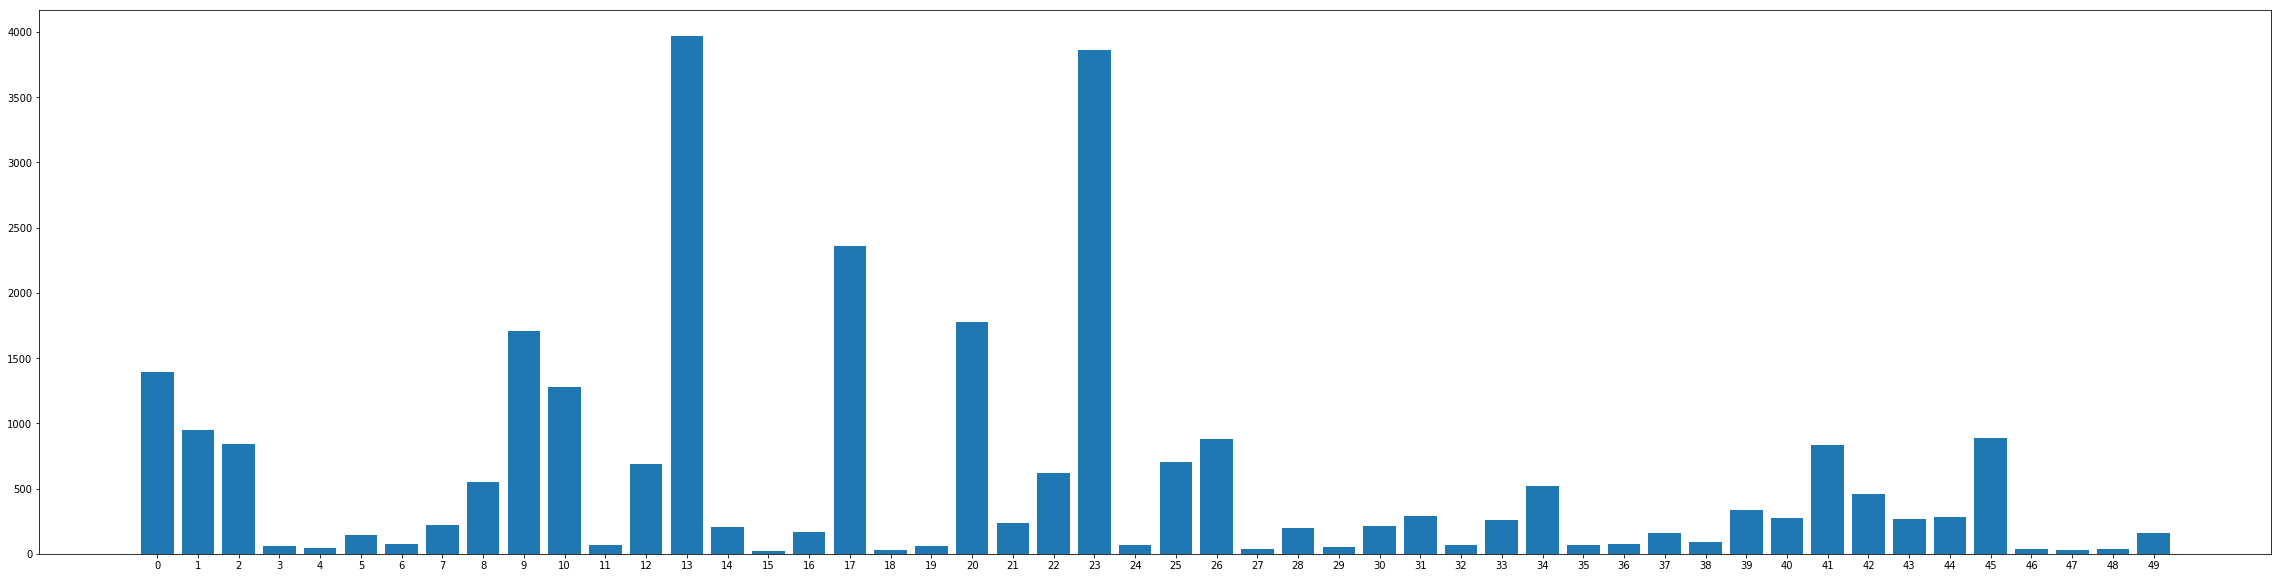

In [38]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(40,10))
plt.bar(range(len(before)), list(before.values()), align='center')
plt.xticks(range(len(before)), list(before.keys()))
plt.show()

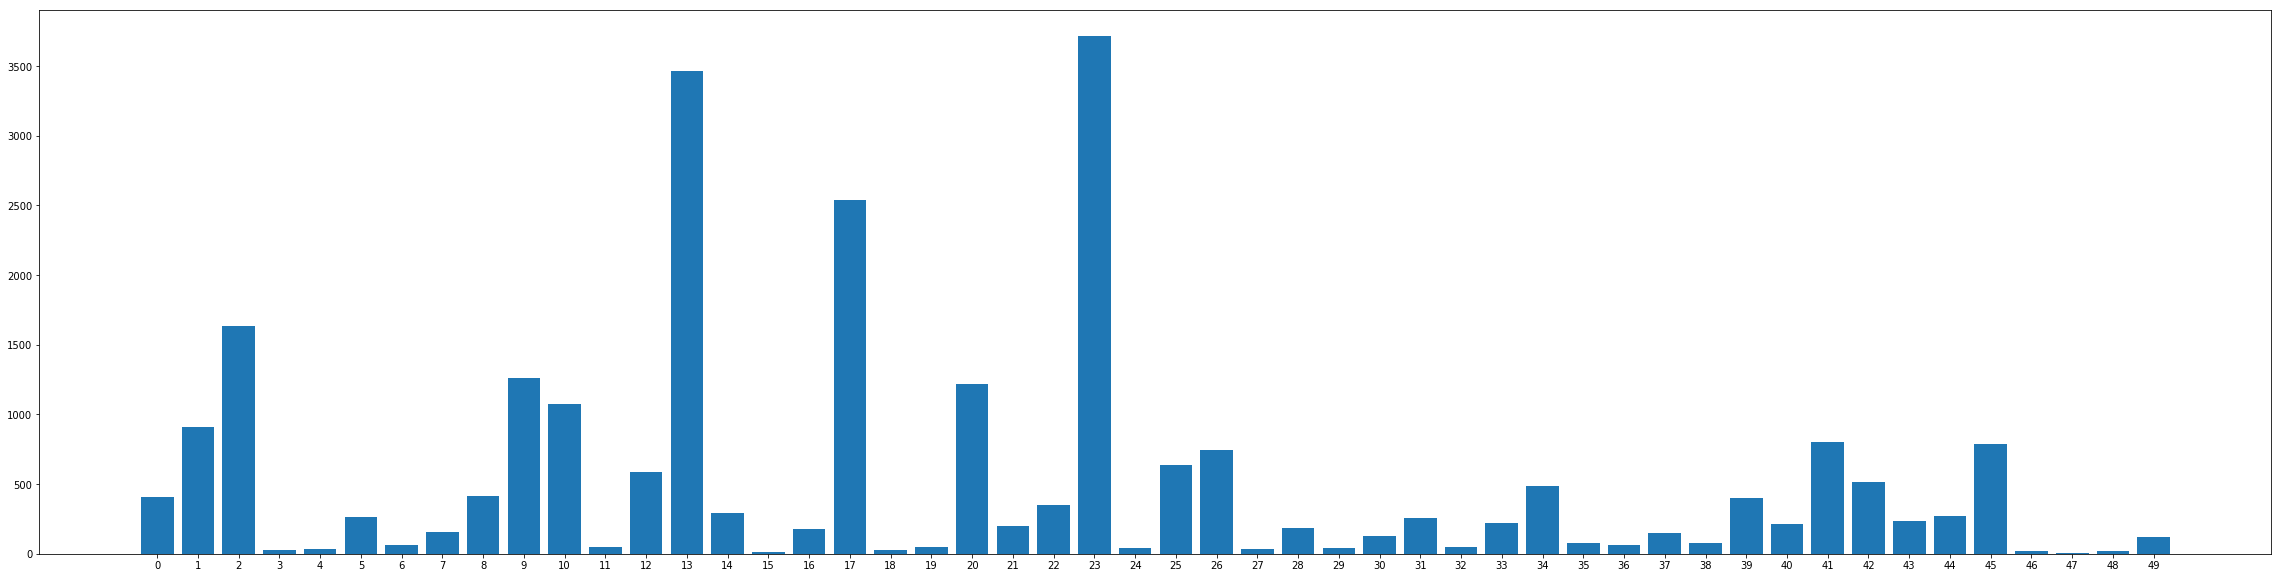

In [46]:
plt.figure(figsize=(40,10))
plt.bar(range(len(after)), list(after.values()), align='center')
plt.xticks(range(len(after)), list(after.keys()))
plt.show()

In [62]:
before_percentage = {}
s = sum(before.values())
for k, v in before.items():
    pct = v * 100.0 / s
    before_percentage[k] = pct

after_percentage = {}
s = sum(after.values())
for k, v in after.items():
    pct = v * 100.0 / s
    after_percentage[k] = pct

50
50


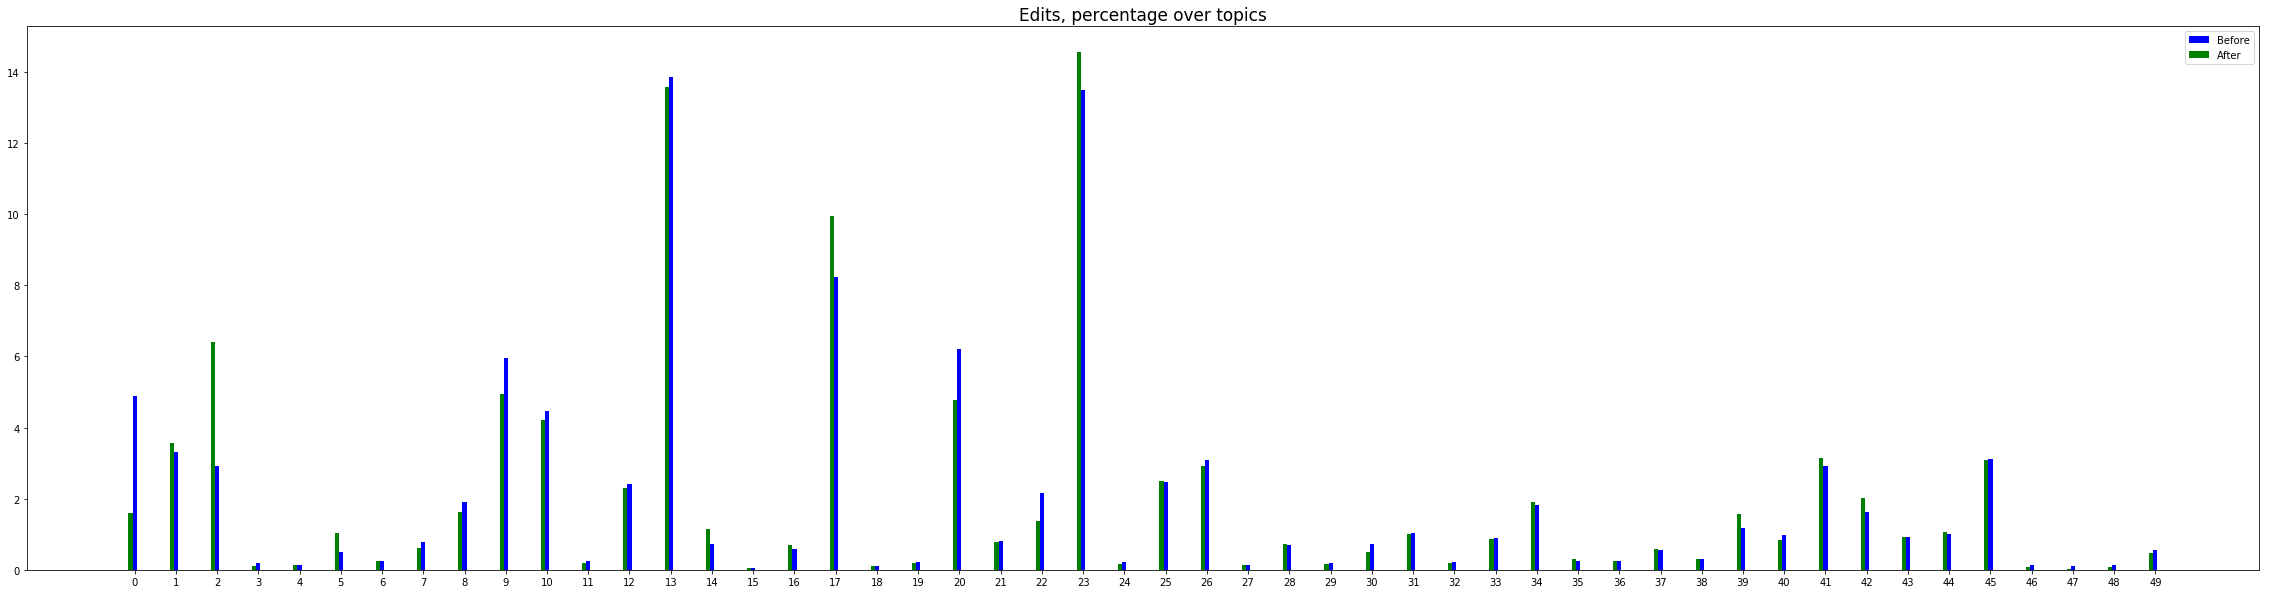

In [67]:
plt.rcParams["figure.figsize"] = (40,10)
X = np.arange(len(before_percentage))
ax = plt.subplot(111)
ax.bar(X, before_percentage.values(), width=0.1, color='b', align='center')
ax.bar(X-0.1, after_percentage.values(), width=0.1, color='g', align='center')
ax.legend(('Before','After'))
plt.xticks(X, before_percentage.keys())
plt.title("Edits, percentage over topics", fontsize=17)
plt.show()

In [75]:
def print_topic_words(topic_nr):
    words = ldamodel.show_topic(topic_nr, topn = 10)
    for w in words:
        print w[0]

print 'topic 0'
print_topic_words(0)

print 'topic 2'
print_topic_words(2)

print 'topic 17'
print_topic_words(17)

print 'topic 23'
print_topic_words(23)

topic 0
arap
mısır
petrol
bronz
kış
suudi
isveç
mardin
dinî
sezonunu
topic 2
yer
alan
nüfus
şehrin
tarihinde
edilmiştir.
tespit
nüfusu
amerika
birleşik
topic 17
bulunan
şehir
nüfusu
merkezi
bağlı
yılı
şehrin
km²
azerbaycan
şehri
topic 23
büyük
yer
yılında
bulunan
doğu
kuzey
batı
arasında
güney
alan


In [83]:
# Test statistic difference of the dicts

from scipy.stats import chisquare
def get_freqs_for_chisq(dict1, dict2):
    for key in (set(dict1) & set(dict2)):
        yield key
        for d in [dict1, dict2]:
            other_freq = sum([v for (k,v) in d.iteritems() if k != key])
            freq = d[key]
            yield np.array([freq, other_freq])

iter = get_freqs_for_chisq(before, after)
results = {}
while True:
    try:
        word = iter.next()
        results[word] = dict(zip(('chisq', 'P'),
                                chisquare(iter.next(), f_exp=iter.next())))
    except StopIteration:
        break

#print results
for k, v in results.iteritems():
    if v['P'] >= 0.05:
        print k, v

{0: {'P': 0.0, 'chisq': 2575.902586566664}, 1: {'P': 4.6074167323163338e-85, 'chisq': 381.98197299492205}, 2: {'P': 1.0733673247568078e-224, 'chisq': 1024.0314866037711}, 3: {'P': 7.9993728005060176e-88, 'chisq': 394.6616027628429}, 4: {'P': 3.1498006847454693e-84, 'chisq': 378.14749582215018}, 5: {'P': 1.3594628214022824e-103, 'chisq': 467.1159307882138}, 6: {'P': 5.6818310584548672e-84, 'chisq': 376.97072755966371}, 7: {'P': 1.3316180266219016e-87, 'chisq': 393.64493577172522}, 8: {'P': 2.2610866102352043e-87, 'chisq': 392.58870761046381}, 9: {'P': 2.2541547823183702e-99, 'chisq': 447.72609155364569}, 10: {'P': 5.6609777949602644e-85, 'chisq': 381.57118483290247}, 11: {'P': 8.2894563245606425e-85, 'chisq': 380.81039481687958}, 12: {'P': 3.2003930324152683e-84, 'chisq': 378.11571054460308}, 13: {'P': 2.4449303034117832e-84, 'chisq': 378.65281250445906}, 14: {'P': 2.7139766748379273e-95, 'chisq': 428.97671699063733}, 15: {'P': 1.7025452609042601e-84, 'chisq': 379.37470231729054}, 16: {

### Result Topics Example (First run)
1   0.010*"kız" + 0.009*"babası" + 0.009*"gün" + 0.008*"geri" + 0.008*"annesi" + 0.008*"son" + 0.007*"genç" + 0.007*"kızı" + 0.007*"oğlu" + 0.007*"birlikte" 

2   0.012*"akciğer" + 0.008*"yunan" + 0.007*"resim" + 0.006*"atina" + 0.005*"yunanistan" + 0.005*"scott" + 0.004*"kanser" + 0.004*"italya'ya" + 0.004*"jackson" + 0.004*"yunanistan'ın" 

3   0.024*"hava" + 0.019*"bağlı" + 0.012*"hüseyin" + 0.012*"olan," + 0.010*"iran" + 0.009*"silahlı" + 0.009*"sahip," + 0.009*"nüfuslu" + 0.008*"kuvvetleri" + 0.008*"cumhurbaşkanlığı" 

4   0.021*"bulunan" + 0.017*"han" + 0.016*"yüzölçümü" + 0.016*"yahudi" + 0.014*"()," + 0.014*"itibarı" + 0.012*"tarihi" + 0.010*"güney" + 0.010*"havalimanı" + 0.009*"yılı" 

5   0.027*"ilk" + 0.019*"sezonunda" + 0.019*"gol" + 0.019*"sezon" + 0.017*"transfer" + 0.016*"maçta" + 0.016*"oldu." + 0.014*"millî" + 0.013*"forma" + 0.013*"lig" 

6   0.024*"köy" + 0.014*"adı" + 0.011*"eski" + 0.011*"köyü" + 0.011*"göç" + 0.010*"ilçe" + 0.009*"bulunmaktadır." + 0.008*"bağlı" + 0.008*"yerleşim" + 0.008*"tarım" 

7   0.025*"japon" + 0.021*"altın" + 0.021*"yaz" + 0.019*"madalya" + 0.012*"nba" + 0.012*"erkekler" + 0.011*"olimpiyat" + 0.011*"dünya" + 0.011*"gümüş" + 0.011*"olimpiyatları'nda" 

8   0.019*"yılında" + 0.014*"büyük" + 0.009*"üretim" + 0.008*"hizmet" + 0.008*"ilk" + 0.008*"sanayi" + 0.008*"şirket" + 0.008*"şirketi" + 0.008*"satın" + 0.007*"ticari" 

9   0.027*"yarı" + 0.013*"elektron" + 0.009*"tank" + 0.009*"eurovision" + 0.009*"adet" + 0.009*"ulusal" + 0.008*"top" + 0.008*"fotoğraf" + 0.007*"finalde" + 0.007*"balık" 

10   0.082*"align="center"" + 0.023*"futbol" + 0.023*"colspan="4"" + 0.017*"toplam" + 0.013*"ligi" + 0.012*"türkiye" + 0.012*"sayısı" + 0.011*"sonuçlar" + 0.011*"fifa" + 0.010*"uefa" 

11   0.046*"yılında" + 0.023*"arasında" + 0.020*"olmuştur." + 0.012*"yılları" + 0.012*"yıllarında" + 0.007*"döneminde" + 0.007*"almıştır." + 0.007*"anadolu" + 0.005*"bulunmuştur." + 0.005*"etmiştir." 

12   0.066*"the" + 0.025*"and" + 0.010*"for" + 0.009*"david" + 0.009*"listesi" + 0.007*"los" + 0.007*"michael" + 0.006*"city" + 0.006*"black" + 0.005*""the" 

13   0.022*"bilim" + 0.012*"üzerine" + 0.009*"bilimsel" + 0.007*"alanında" + 0.007*"fizik" + 0.006*"felsefe" + 0.006*"von" + 0.005*"hasan" + 0.005*"çalışmalar" + 0.004*"müdürlüğü," 

14   0.009*"büyük" + 0.008*"ortaya" + 0.008*"zaman" + 0.007*"gelen" + 0.006*"aynı" + 0.006*"sadece" + 0.006*"önemli" + 0.006*"özellikle" + 0.005*"başka" + 0.005*"farklı" 

15   0.033*"yılında" + 0.032*"tarihinde" + 0.015*"ilk" + 0.011*"mayıs" + 0.011*"olmuştur." + 0.010*"2012" + 0.009*"dünya" + 0.009*"2014" + 0.009*"2013" + 0.009*"2008" 

16   0.018*"enerji" + 0.012*"yüksek" + 0.010*"elektrik" + 0.009*"güneş" + 0.009*"nükleer" + 0.008*"kimyasal" + 0.007*"madde" + 0.007*"kullanılır." + 0.007*"hücre" + 0.006*"meydana" 

17   0.011*"küçük" + 0.010*"kara" + 0.010*"beyaz" + 0.009*"deniz" + 0.009*"güney" + 0.008*"bulunur." + 0.008*"alt" + 0.007*"türü" + 0.007*"bitki" + 0.007*"kuzey" 

18   0.045*"film" + 0.027*"filmin" + 0.023*"yapımı" + 0.022*"sinema" + 0.017*"rol" + 0.016*"tiyatro" + 0.016*"filmi" + 0.015*"televizyon" + 0.015*"filmde" + 0.014*"oyuncu" 

19   0.061*"(d." + 0.037*"futbolcudur." + 0.029*"yılında" + 0.029*"profesyonel" + 0.025*"görev" + 0.024*"başladı." + 0.023*"eski" + 0.021*"millî" + 0.020*"kariyerine" + 0.016*"oynadı." 

20   0.008*"inşa" + 0.008*"ilk" + 0.007*"adet" + 0.006*"istanbul" + 0.006*"türkiye'nin" + 0.006*"bulunmaktadır." + 0.005*"önemli" + 0.005*"yıllarda" + 0.004*"bulunan" + 0.004*"edilen" 

21   0.029*"osmanlı" + 0.014*"ii." + 0.012*"bizans" + 0.012*"oğlu" + 0.010*"büyük" + 0.009*"üzerine" + 0.008*"islam" + 0.007*"muhammed" + 0.007*"tahta" + 0.007*"idi." 

22   0.021*"genel" + 0.021*"türk" + 0.017*"görev" + 0.015*"(d." + 0.014*"devlet" + 0.014*"ankara" + 0.013*"dönem" + 0.013*"istanbul" + 0.012*"yapmıştır." + 0.012*"arasında" 

23   0.022*"genel" + 0.011*"seçimleri" + 0.011*"türkiye" + 0.008*"motor" + 0.008*"sonuçlandı." + 0.007*"wwe" + 0.007*"euro" + 0.006*"zamanlı" + 0.005*"anahtar" + 0.005*"haftada" 

24   0.030*"müzik" + 0.021*"şarkı" + 0.021*"ilk" + 0.015*"albümü" + 0.014*"albüm" + 0.013*"grup" + 0.012*"adlı" + 0.011*"yer" + 0.010*"grubun" + 0.010*"albümün" 

25   0.009*"israil" + 0.006*"atom" + 0.006*"optik" + 0.005*"hakkında" + 0.004*"cup" + 0.004*"yük" + 0.004*"sonuç" + 0.004*"iddia" + 0.004*"parçacık" + 0.004*"dini" 

26   0.044*"yılında" + 0.025*"oldu." + 0.020*"aldı." + 0.015*"başladı." + 0.015*"yaptı." + 0.014*"(d." + 0.014*"adlı" + 0.013*"etti." + 0.012*"ilk" + 0.011*"yıl" 

27   0.024*"ilk" + 0.019*"dünya" + 0.017*"ikinci" + 0.015*"kazandı." + 0.014*"oldu." + 0.013*"takım" + 0.010*"son" + 0.010*"grand" + 0.009*"finalde" + 0.009*"maçı" 

28   0.018*"anlamlara" + 0.015*"gelebilir:" + 0.013*"del" + 0.011*"san" + 0.011*"(anlam" + 0.011*"ayrımı)" + 0.009*"aşağıdaki" + 0.006*"topu" + 0.006*"kızılderili" + 0.005*"antonio" 

29   0.015*"kadın" + 0.006*"toplumsal" + 0.006*"roman" + 0.005*"kadınların" + 0.005*"sosyal" + 0.005*"kitabın" + 0.004*"kadınlar" + 0.004*"düşünce" + 0.004*"insan" + 0.004*"insanların" 

30   0.032*"iyi" + 0.017*""the" + 0.016*"film" + 0.015*"ödülü" + 0.012*"yer" + 0.010*"john" + 0.010*"stüdyo" + 0.008*"amerikan" + 0.008*"ödül" + 0.008*"listesinde" 

31   0.019*"siyah" + 0.014*"kırmızı" + 0.013*"mavi" + 0.013*"renkli" + 0.011*"sarı" + 0.011*"koyu" + 0.010*"yeşil" + 0.009*"familyasından" + 0.009*"renk" + 0.008*"lee" 

32   0.073*"birleşik" + 0.051*"amerika" + 0.028*"abd" + 0.018*"amerikan" + 0.014*"ilçenin" + 0.012*"merkezi" + 0.011*"krallık" + 0.011*"itibarıyla" + 0.010*"abd'nin" + 0.010*"yılı" 

33   0.015*"savaş" + 0.013*"karşı" + 0.012*"savaşı" + 0.010*"askeri" + 0.009*"alman" + 0.009*"sırasında" + 0.009*"yılında" + 0.009*"ordusu" + 0.008*"ii." + 0.008*"ele" 

34   0.012*"oyun" + 0.012*"yeni" + 0.012*"windows" + 0.010*"ilk" + 0.008*"web" + 0.008*"bilgisayar" + 0.007*"oyunun" + 0.006*"video" + 0.006*"veri" + 0.006*"piyasaya" 

35   0.016*"ilk" + 0.016*"adlı" + 0.007*"aynı" + 0.007*"yazar" + 0.006*"hakkında" + 0.006*"kitap" + 0.006*"yazdığı" + 0.005*"kitabı" + 0.004*"eseri" + 0.004*"konu" 

36   0.034*"yoktur." + 0.031*"köyün" + 0.028*"vardır." + 0.028*"ilçesine" + 0.025*"sağlık" + 0.024*"şebekesi" + 0.023*"ptt" + 0.022*"mahallenin" + 0.016*"bağlı" + 0.015*"ilinin" 

37   0.029*"yer" + 0.021*"bulunan" + 0.016*"büyük" + 0.013*"şehir" + 0.012*"alan" + 0.009*"bağlı" + 0.009*"bulunmaktadır." + 0.009*"kuzey" + 0.009*"merkezi" + 0.009*"almaktadır." 

38   0.018*"avrupa" + 0.015*"doğu" + 0.014*"batı" + 0.012*"arasında" + 0.009*"barış" + 0.009*"ülke" + 0.008*"büyük" + 0.008*"fransa" + 0.007*"hollanda" + 0.007*"almanya" 

39   0.011*"mısır" + 0.010*"sivas" + 0.009*"bulunan" + 0.008*"suriye" + 0.007*"selçuklu" + 0.007*"gayet" + 0.007*"hacı" + 0.006*"şeyh" + 0.006*"ağa" + 0.006*"saray" 

40   0.021*"new" + 0.014*"york" + 0.011*"söyler." + 0.008*"eder." + 0.007*"cinsel" + 0.007*"oyunculuk" + 0.006*"eve" + 0.005*"seyahat" + 0.005*"canlandırdığı" + 0.005*"vize" 

41   0.008*"internet" + 0.007*"bilgi" + 0.007*"temel" + 0.006*"sistemi" + 0.005*"açık" + 0.005*"yeni" + 0.005*"sistem" + 0.005*"para" + 0.004*"kontrol" + 0.004*"özel" 

42   0.014*"uzay" + 0.008*"güneş" + 0.008*"dalga" + 0.007*"aynı" + 0.007*"zaman" + 0.006*"ifade" + 0.006*"yıldız" + 0.006*"alan" + 0.005*"temel" + 0.005*"manyetik" 

43   0.014*"ilk" + 0.011*"büyük" + 0.009*"yılında" + 0.008*"fransız" + 0.008*"yeni" + 0.006*"yıl" + 0.006*"dünya" + 0.005*"arasında" + 0.005*"ingiliz" + 0.005*"önemli" 

44   0.029*"yılında" + 0.024*"eğitim" + 0.023*"üniversitesi" + 0.013*"uluslararası" + 0.012*"türk" + 0.010*"yüksek" + 0.009*"istanbul" + 0.008*"öğretim" + 0.008*"kültür" + 0.007*"türkiye" 

45   0.021*"çin" + 0.012*"kan" + 0.007*"tıbbi" + 0.007*"sinir" + 0.006*"çin'in" + 0.006*"kalın" + 0.005*"insan" + 0.005*"hindistan" + 0.005*"hint" + 0.005*"besin" 

46   0.052*"şehrin" + 0.045*"yer" + 0.042*"alan" + 0.040*"nüfus" + 0.036*"nüfusu" + 0.033*"tarihinde" + 0.029*"edilmiştir." + 0.027*"tespit" + 0.025*"amerikan," + 0.025*"şehirdir." 

47   0.046*"türk" + 0.033*"ali" + 0.027*"paşa" + 0.023*"mustafa" + 0.020*"mehmet" + 0.016*"ahmet" + 0.014*"bey" + 0.013*"sultan" + 0.013*"kemal" + 0.012*"ibrahim" 

48   0.009*"yüksek" + 0.008*"kullanılan" + 0.007*"genellikle" + 0.007*"farklı" + 0.006*"sahip" + 0.006*"yaklaşık" + 0.006*"küçük" + 0.006*"ışık" + 0.005*"bulunan" + 0.005*"aynı" 

49   0.013*"yılı" + 0.013*"kişi" + 0.011*"2006" + 0.010*"resmi" + 0.010*"dil" + 0.009*"yönetim" + 0.008*"iran'ın" + 0.008*"bulgar" + 0.008*"merkezi" + 0.008*"posta" 

50   0.008*"karşı" + 0.005*"yeni" + 0.005*"devlet" + 0.005*"birliği" + 0.005*"siyasi" + 0.005*"sovyet" + 0.004*"etti." + 0.004*"kabul" + 0.004*"ardından" + 0.004*"sovyetler"

### Translation of result (Google translate)

0 "daughter" +0.009 * "father" + 0.009 * "day" + 0.008 * "back" + 0.008 * "mother" + 0.008 * "last" + 0.007 * "young" + 0.007 * "daughter" + 0.007 * "son" + 0.007 * "together"

2 0.012 * "lung" + 0.008 * "greek" + 0.007 * "picture" + 0.006 * "Athina" + 0.005 * "greece" + 0.005 * "scott" + 0.004 * "cancer" + 0.004 * "to Italy" + 0.004 * "jackson" + 0.004 * "of greece's"

3 "0.020" + 0.019 * "h." + "0.012" "," + 0.010 * "with" + "+ 0.009 + 0.008 * "forces" + 0.008 * "presidency"

4 0.017 * "located" + 0.016 * "area" + 0.016 * "area" + 0.016 * "Jewish" + 0.014 * "()," + 0.014 * "" "0.010 *" + 0.010 * "airport" + 0.009 * "year"

5 0.019 * "in the season" + 0.019 * "goal" + 0.019 * "season" + 0.017 * "transfer" + 0.016 * "match" + 0.016 * "was. + 0.014 * "national" + 0.013 * "uniform" + 0.013 * "league"

6 0.024 * "village" + 0.014 * "name" + 0.011 * "old" + 0.011 * "village" + 0.011 * "migration" + 0.010 * "district" + 0.009 * "are located." + 0.008 * "bound" + 0.008 * "settlement" + 0.008 * "agriculture"

7 0.021 * "gold" + 0.021 * "summer" + 0.019 * "medal" + 0.012 * "nba" + 0.012 * "men" + 0.011 * "world" + 0.011 * * "Silver" + 0.011 * "Olympics"

8 0.019 * "in" + 0.014 * "large" + 0.009 * "production" + 0.008 * "service" + 0.008 * "initial" + 0.008 * "industry" + 0.008 * "company" + 0.008 * "company" + 0.008 * "Buy" + 0.007 * "commercial"

+0.09 * "electron" + 0.009 * "tank" + 0.009 * "eurovision" + 0.009 * "pcs" + 0.009 * "national" + 0.008 * "ball" + 0.008 * "photo" + 0.007 * "final" + 0.007 * "fish"

10 0082 * "align =" center "" + 0.023 * "football" + 0.023 * "colspan =" 4 "" + 0.017 * "total" + 0.013 * "league" + 0.012 * "turkey" + 0.012 * "count" + 0.011 * "results" + 0.011 * "fifa" + 0.010 * "uefa"

11 in 0.046 * "+ 0.022" "was" + 0.020 * ". + 0.012 * "years" + 0.012 * "+ 0.007 *" in the period "+ 0.007 *" has received. " + 0.007 * "anadolu" + 0.005 * "found." + 0.005 * "has."

12 0.025 * "and" + 0.010 * "for" + 0.009 * "david" + 0.009 * "list" + 0.007 * "los" + 0.007 * "michael" + 0.006 * "city" + 0.006 * "black" + 0.005 * "" the "

13 0.022 * "science" + 0.012 * "+ 0.009 *" in the area of ​​"scientific" + 0.007 * "+ 0.007 *" physics "+ 0.006 *" philosophy "+ 0.006 *" von "+ 0.005 *" hasan "+ 0.005 * "studies" + 0.004 * "directorate,"

14 0.009 * "large" + 0.008 * "emerged" + 0.008 * "time" + 0.007 * "incoming" + 0.006 * "same" + 0.006 * "only" + 0.006 * "significant" + 0.006 * "in particular" + 0.005 * "other" + 0.005 * "different"

15 0.032 * "on" + 0.015 * "on" + 0.015 * "to" + 0.011 * "may" + 0.011 * " + 0.010 * "2012" + 0.009 * "world" + 0.009 * "2014" + 0.009 * "2013" + 0.009 * "2008"

16 0.018 * "energy" + 0.010 * "high" + 0.010 * "electrical" + 0.009 * "solar" + 0.009 * "nuclear" + 0.008 * "chemical" + 0.007 * "substance" + 0.007 * "is used." + 0.007 * "cell" + 0.006 * "occurring"

17 0.011 * "small" + 0.010 * "black" + 0.010 * "white" + 0.009 * "sea" + 0.009 * "south" + 0.008 * "located." + 0.008 * "bottom" + 0.007 * "type" + 0.007 * "plant" + 0.007 * "north"

18 0.022 * "theater" + 0.016 * "theater" + 0.016 * "theater" + 0.016 * "theater" + 0.016 * "movie" + 0.011 * "In the movie" + 0.014 * "Player"

19 0.061 * "(d." + 0.037 * "is the footballer." + 0.029 * "in the year" + 0.029 * "Professional" + 0.025 * "Quest" + 0.024 * "Started." + 0.023 * "Old" + 0.021 * " national "+ 0.020 *" to his career "+ 0.016 *" played. "

20, 0008 * "build" + 0.008 * "first" + 0.007 * "Total" + 0.006 * "Istanbul" + 0.006 * "Turkey's" + 0.006 * "are available." + 0.005 * "significant" + 0.005 * "" + 0.004 * "found" + 0.004 * "in the"

21 0.029 * "ottoman" + 0.014 * "ii." + 0.012 * "Byzantine" + 0.012 * "son of" + 0.010 * "large" + 0.009 * "on + 0.008 *" Islam "+ 0.007 *" Muhammad "+ 0.007 *" board "+ 0.007 *". "

22 0.021 * "turkish" + 0.017 * "duty" + 0.015 * "(d." + 0.014 * "state" + 0.014 * "ankara" + 0.013 * "period" + 0.013 * "istanbul") + 0.012 * "between." + 0.012 * "between"

23, 0022 * "general" + 0.011 * "elections" + 0.011 * "turkey" + 0.008 * "engine" + 0.008 * "resulted." + 0.007 * "wwe" + 0.007 * "euro" + 0.006 * "timed" + 0.005 * "key" + 0.005 * "per week"

 340.20 * "music" + 0.021 * "song" + 0.021 * "first" + 0.015 * "album" + 0.014 * "album" + 0.013 * "group" + 0.012 * "named" + 0.011 * "place" + 0.010 * "of the band" + 0.010 * "album's"

25 0.004 * "atom" + 0.006 * "optical" + 0.005 * "about" + 0.004 * "cup" + 0.004 * "load" + 0.004 * "result" + 0.004 * "claim" + 0.004 * "particle" + 0.004 * "religious"

26 0.044 * "in" + 0.025 * "." + 0.020 * "received." + 0.015 * "started." + 0.015 * "did." + 0.014 * "(d." + 0.014 * "named" + 0.013 * "." + 0.012 * "first" + 0.011 * "year"

27 "First" + 0.019 * "world" + 0.017 * "second" + 0.015 * "won." + 0.014 * "was." + 0.013 * "team" + 0.010 * "last" + 0.010 * "grand" + 0.009 * "in the final" + 0.009 * "match"

28 0.018 * "meanings" + 0.015 * "may come:" + 0.013 * "del" + 0.011 * "san" + 0.011 * "(meaning" + 0.011 * "separation)" + 0.009 * "the following" + 0.006 * "ball + 0.006 * "indian" + 0.005 * "antonio"

29 0.005 * "women" + 0.005 * "social" + 0.005 * "social" + 0.005 * "social" + 0.005 * "social" + 0.005 * "women" + 0.005 * "social" + 0.005 * "book" + 0.004 * "women" + 0.004 * "thought" + 0.004 * "human" + 0.004 * "people"

30 0.010 * "film" + 0.015 * "award" + 0.010 * "place" + 0.010 * "john" + 0.010 * "studio" + 0.001 * "american" + 0.008 * "reward" + 0.008 * "in the list"

31 "Black" + 0.014 * "red" + 0.013 * "blue" + 0.013 * "color" + 0.011 * "yellow" + 0.011 * "dark" + 0.010 * "green" + 0.009 * "from the family" + 0.009 * "color" + 0.008 * "lee"

32 0.018 * "united" + 0.051 * "America" ​​+ 0.028 * "US" + 0.014 * "As the town" + 0.012 * "Center" + 0.011 * "Kingdom" + 0.011 * as of "+ 0.010 * "US $" + 0.010 * "year"

33 0.013 * "war" + 0.010 * "war" + 0.010 * "military" + 0.009 * "German" + 0.009 * "during" + 0.009 * "in" + 0.009 * "army" + 0.008 * "i." + 0.008 * "handled"

34 0.012 * "New" + 0.012 * "Windows" + 0.010 * "First" + 0.008 * "Web" + 0.008 * "Computer" + 0.007 * "Game" + 0.006 * "Video" + 0.006 * "data" + 0.006 * "released"

35 0.016 * "first" + 0.016 * "" + 0.007 * "writes" + 0.006 * "author" + 0.006 * "about" + 0.006 * "book" + 0.006 * "wrote" + 0.005 * "book" + 0.004 * "work" + 0.004 * "subject"

36 0.034 * "no." + 0.031 * "village" has + 0.028 * ". + 0.028 * "district" + 0.025 * "health" + 0.023 * "network" + 0.022 * "ptt" + 0.022 * "neighborhood" + 0.016 * "connected" + 0.015 * "of the province"

37 0.029 * "place" + 0.021 * "located" + 0.016 * "large" + 0.013 * "city" + 0.012 * "area" + 0.009 * "connected" + 0.009 * "is located." + 0.009 * "north" + 0.009 * "center" + 0.009 * "takes."

38 0.018 * "Europe" + 0.015 * "East" + 0.014 * "Western" + 0.012 * "between" + 0.009 * "Peace" + 0.009 * "Country" + 0.008 * "Large" + 0.008 * "France" + 0.007 * "Netherlands" + 0.007 * "Germany"

39 0.011 * "maize" + 0.010 * "sivas" + 0.009 * "found" + 0.008 * "Syrian" + 0.007 * "selcuklu" + 0.007 * "fine" + 0.007 * "pilgrimage" + 0.006 * "sheikh" + 0.006 * "network" + 0.006 * "palace"

40 0.021 * "new" + 0.014 * "york" + 0.011 * "tells." + 0.008 * "." + 0.007 * "sexual" + 0.007 * "acting" + 0.005 * "home" + 0.005 * "travel" + 0.005 * "animated" + 0.005 * "visa"

41 0.008 * "information" + 0.007 * "basic" + 0.006 * "system" + 0.005 * "open" + 0.005 * "new" + 0.005 * "system" + 0.005 * "money" + 0.004 * "control" + 0.004 * "special"

42 0.014 * "space" + 0.008 * "wave" + 0.007 * "same" + 0.007 * "time" + 0.006 * "expression" + 0.006 * "star" + 0.006 * "area" + 0.005 * "basic" + 0.005 * "magnetic"

43 0.014 * "initial" + 0.011 * "large" + 0.009 * "in" + 0.008 * "French" + 0.008 * "new" + 0.006 * "year" + 0.006 * "world" + 0.005 * "of" + 0.005 * "British" + 0.005 * "important"

* 0.022 * "education" + 0.023 * "university" + 0.013 * "international" + 0.012 * "turkish" + 0.010 * "university" + 0.010 * "high" + 0.009 * "istanbul" + 0.008 * "teaching" + 0.008 * "culture" + 0.007 * "turkey"

45 0.021 * "china" + 0.012 * "blood" + 0.007 * "medical" + 0.007 * "nerve" + 0.006 * "China's" + 0.006 * "thick" + 0.005 * "human" + 0.005 * "India" + 0.005 * "indian" + 0.005 * "nutrient"

46 0.052 * "city" + 0.045 * "place" + 0.042 * "area" + 0.040 * "population" + 0.036 * "population" + 0.033 * "on" + 0.029 * ". + 0.027 * "detect" + 0.025 * "american," + 0.025 * "is the city."

+ 0.033 * "Turkish" + 0.027 * "Pasha" + 0.023 * "Mustafa" + 0.020 * "Mehmet" + 0.016 * "Ahmet" + 0.014 * "Bey" + 0.013 * "Sultan" + 0.013 * "kemal" + 0.012 * "ibrahim"

48 0.009 * "high" + 0.008 * "used" + 0.007 * "usually" + 0.007 * "having different" + 0.006 * "+ 0.006 *" about "+ 0.006 *" small "+ 0.006 *" light "+ 0.005 * "Located" + 0.005 * "Same"

+ 0.013 * "person" + 0.011 * "2006" + 0.010 * "official" + 0.010 * "language" + 0.009 * "management" + 0.008 * "Iran's" + 0.008 * "bulgarian" + 0.008 * "center" + 0.008 * "mail"

50 0.008 * "against" + 0.005 * "new" + 0.005 * "state" + 0.005 * "union" + 0.005 * "political" + 0.005 * "soviet" + 0.004 * "has." + 0.004 * "accepted" + 0.004 * "then" + 0.004 * "Soviet"

## Based on Categories

In [ ]:
import re
import json
import requests

# get edits before and after block per article
edits_articles_before = {}
with open('edits-per-article-before.json') as infile:
    edits_articles_before = json.load(infile)
edits_articles_after = {}
with open('edits-per-article-after.json') as infile:
    edits_articles_after = json.load(infile)
    
# get edits before and after block per article
edits_articles_before = {}
with open('edits-per-article-before.json') as infile:
    edits_articles_before = json.load(infile)
edits_articles_after = {}
with open('edits-per-article-after.json') as infile:
    edits_articles_after = json.load(infile)
    
# get all article titles we have data on
article_titles = set(edits_articles_after.keys() + edits_articles_before.keys())

# API request

category_before = {}
category_after = {}

counter = 0

for title in article_titles:
    re = requests.get('https://en.wikipedia.org/w/api.php?format=xml&action=query&prop=categories&format=json&titles=' + title)
    data = json.loads(re.text)

    id = data['query']['pages'].keys()[0]
    if not 'categories' in data['query']['pages'][id]:
        continue
    else:
        counter += 1
        print counter
    categories = data['query']['pages'][id]['categories']
    for c in categories:
        if title in edits_articles_before:
            if c['title'] not in category_before:
                category_before[c['title']] = int(edits_articles_before[title])
            else:
                category_before[c['title']] += int(edits_articles_before[title])
        if title in edits_articles_after:
            if c['title'] not in category_after:
                category_after[c['title']] = int(edits_articles_after[title])
            else:
                category_after[c['title']] += int(edits_articles_after[title])